# Multivariate process control by Principal Component Analysis using T² and Q errors

## Data input

In [1]:
import pandas as pd

plant = pd.read_csv("plant_generated.csv")
plant.head()

,group,time,var1,var2,var3,var4,var5
0,train,1,83.346705,28.115372,455.898265,12.808663,227.974152
1,train,2,90.594521,33.497319,462.503195,14.079053,228.173486
2,train,3,101.275664,30.396332,492.407791,16.832834,250.212025
3,train,4,90.898109,29.143537,472.162499,16.505277,234.079354
4,train,5,84.898605,29.459506,467.872180,12.801665,238.440786


In [2]:
variables = plant.columns[2:].tolist()
print(variables)

['var1', 'var2', 'var3', 'var4', 'var5']


In [3]:
plant.groupby(["group"]).agg({"time": [len, min, max]})

time         
       len min  max
group              
test    30   1   30
train  100   1  100

In [4]:
plant.loc[plant.group=="train", variables].corr()

,var1,var2,var3,var4,var5
var1,1.000000,0.536242,0.773872,0.534615,0.727272
var2,0.536242,1.000000,0.535442,0.451099,0.632337
var3,0.773872,0.535442,1.000000,0.613662,0.709600
var4,0.534615,0.451099,0.613662,1.000000,0.571399
var5,0.727272,0.632337,0.709600,0.571399,1.000000


## Data exploration

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [6]:
train_melt = plant.loc[plant.group=="train", variables].\
    join(plant.loc[:,["time","group"]]).\
    melt(id_vars=["group","time"], value_vars=variables)

train_melt.head()

,group,time,variable,value
0,train,1,var1,83.346705
1,train,2,var1,90.594521
2,train,3,var1,101.275664
3,train,4,var1,90.898109
4,train,5,var1,84.898605


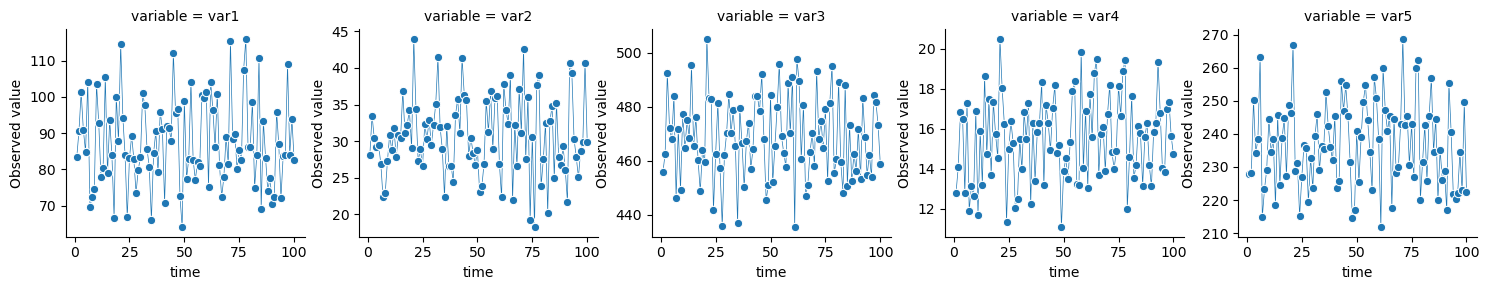

In [7]:
graph = sns.FacetGrid(train_melt, col="variable", sharey=False)
graph.map_dataframe(sns.lineplot, x="time", y="value", lw=0.5, marker="o")
graph.set(ylabel="Observed value")

## Data preprocessing

In [8]:
import numpy as np
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = np.array(plant.loc[plant.group=="train", variables])
Z_train = scaler.fit_transform(X_train)

In [9]:
scaled_train = pd.DataFrame(Z_train, columns=variables).\
    join(plant.loc[:,["time","group"]]).\
    melt(id_vars=["group","time"], value_vars=variables)

scaled_train.head()

,group,time,variable,value
0,train,1,var1,-0.339427
1,train,2,var1,0.265225
2,train,3,var1,1.156304
3,train,4,var1,0.290552
4,train,5,var1,-0.209959


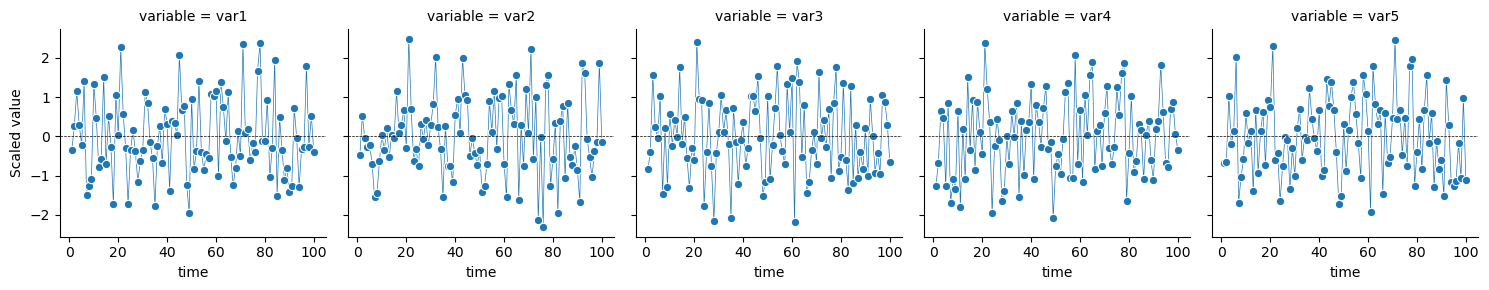

In [10]:
graph = sns.FacetGrid(scaled_train, col="variable")
graph.map_dataframe(sns.lineplot, x="time", y="value", lw=0.5, marker="o")
graph.set(ylabel="Scaled value")
x_axes = graph.axes.flatten()
for ax in x_axes:
  ax.axhline(0, ls="--", lw=0.5, c="black")

## Building the PCA

In [11]:
u, s, vh = np.linalg.svd(Z_train)
loadings = np.transpose(vh)
print(loadings)

[[ 0.46831293 -0.07447163  0.50970523  0.1634115  -0.69902377]
 [ 0.40387459  0.76147727 -0.41265167  0.29133908 -0.04333374]
 [ 0.47556921 -0.21952275  0.30115426  0.43988217  0.66441965]
 [ 0.40644337 -0.58699292 -0.68019685 -0.01720318 -0.16516475]
 [ 0.47561121  0.14783576  0.12867607 -0.83344223  0.20187888]]


In [12]:
pc_names = ["PC"+str(j+1) for j in range(len(variables))]
print(pc_names)

['PC1', 'PC2', 'PC3', 'PC4', 'PC5']


In [13]:
train_scores = Z_train @ loadings

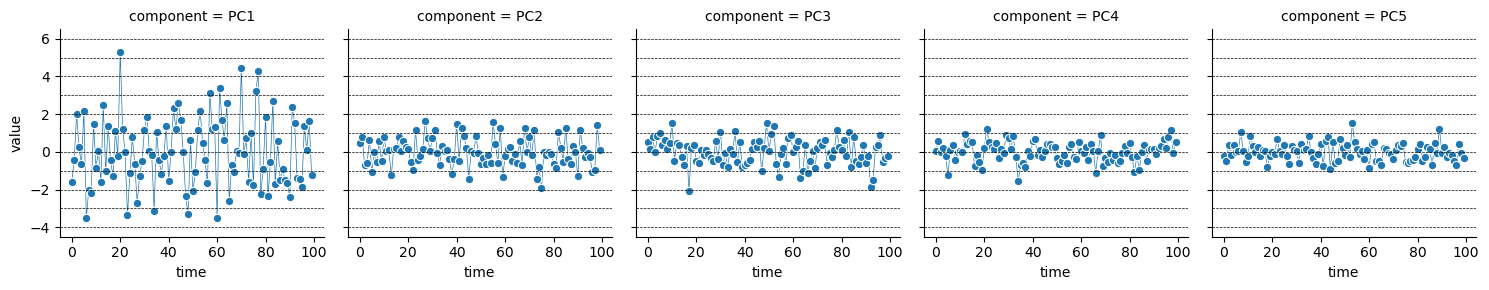

In [14]:
scores = train_scores
scores_df = pd.DataFrame(scores, columns=pc_names)
scores_df["time"] = [*range(scores.shape[0])]
scores_df = pd.melt(scores_df, id_vars="time", var_name="component", value_vars=pc_names)
graph = sns.FacetGrid(scores_df, col="component", sharex=False)
graph.map_dataframe(sns.lineplot, x="time", y="value", lw=0.5, marker="o")
x_axes = graph.axes.flatten()
for ax in x_axes:
  for i in range(-4,7):
    ax.axhline(i, ls="--", lw=0.5, c="black")

In [15]:
n = Z_train.shape[0]

variances = s**2 / (n - 1)

In [16]:
pd.DataFrame({
    "Component": [*range(1, len(s)+1)],
    "Variance": variances,
    "Proportion": variances/np.sum(variances),
    "Cumulative": np.cumsum(variances/np.sum(variances))
})

,Component,Variance,Proportion,Cumulative
0,1,3.485770,0.690182,0.690182
1,2,0.573965,0.113645,0.803828
2,3,0.498244,0.098652,0.902480
3,4,0.276403,0.054728,0.957208
4,5,0.216122,0.042792,1.000000


In [17]:
n_comp = 2
pca_loadings = loadings[:,:n_comp]
pca_variances = variances[:n_comp]

## Evaluating new data

In [18]:
X_test = np.array(plant.loc[plant.group=="test", variables])
Z_test = scaler.transform(X_test)

In [19]:
scaled_test = pd.DataFrame(Z_test, columns=variables).\
    join(plant.loc[:,["time","group"]]).\
    melt(id_vars=["group","time"], value_vars=variables)

scaled_test.head()

,group,time,variable,value
0,train,1,var1,-1.185547e-15
1,train,2,var1,1.069045e+00
2,train,3,var1,1.511858e+00
3,train,4,var1,1.851640e+00
4,train,5,var1,2.138090e+00


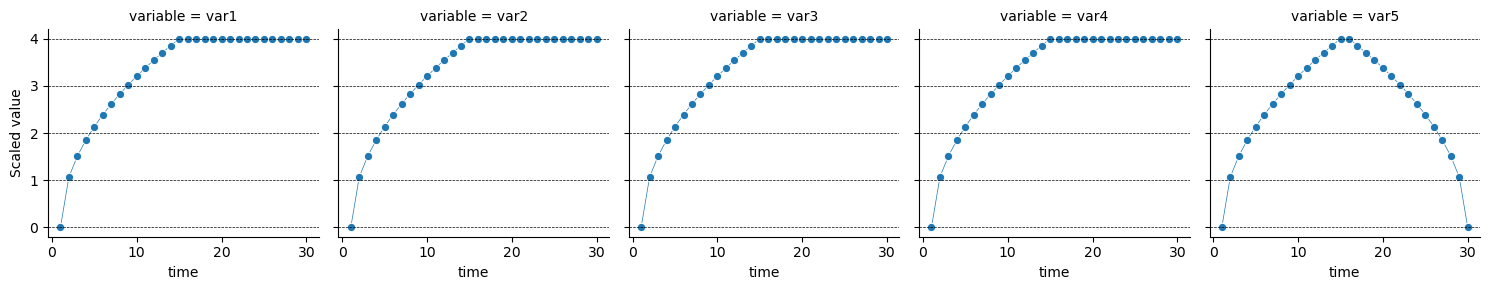

In [20]:
graph = sns.FacetGrid(scaled_test, col="variable")
graph.map_dataframe(sns.lineplot, x="time", y="value", lw=0.5, marker="o")
graph.set(ylabel="Scaled value")
x_axes = graph.axes.flatten()
for ax in x_axes:
    for i in range(5):
        ax.axhline(i, ls="--", lw=0.5, c="black")

In [21]:
test_scores = Z_test @ pca_loadings
test_expect = test_scores @ np.transpose(pca_loadings)

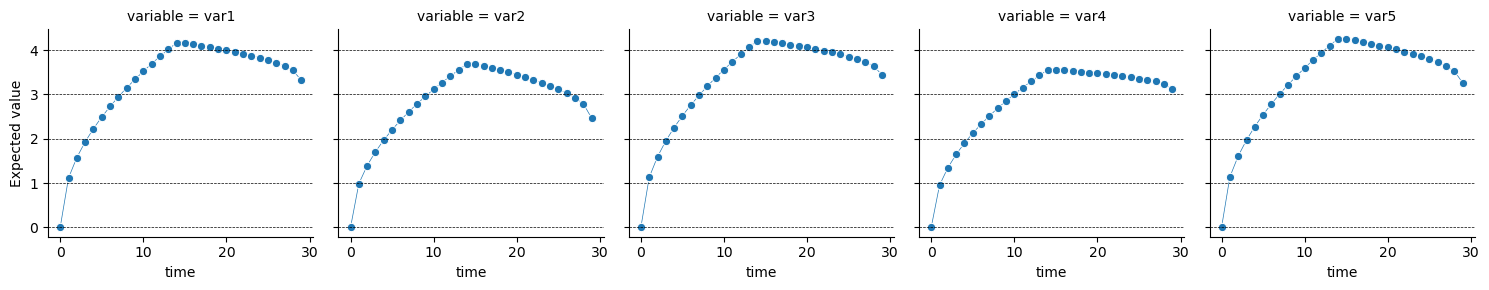

In [22]:
df = pd.DataFrame(test_expect, columns=variables).\
    reset_index().\
    melt(id_vars=["index"], value_vars=variables).\
    rename(columns={"index": "time"})
graph = sns.FacetGrid(df, col="variable")
graph.map_dataframe(sns.lineplot, x="time", y="value", lw=0.5, marker="o")
graph.set(ylabel="Expected value")
x_axes = graph.axes.flatten()
for ax in x_axes:
  for i in range(0,5):
    ax.axhline(i, ls="--", lw=0.5, c="black")

### Q contributions

In [23]:
contrib_Q = Z_test - test_expect

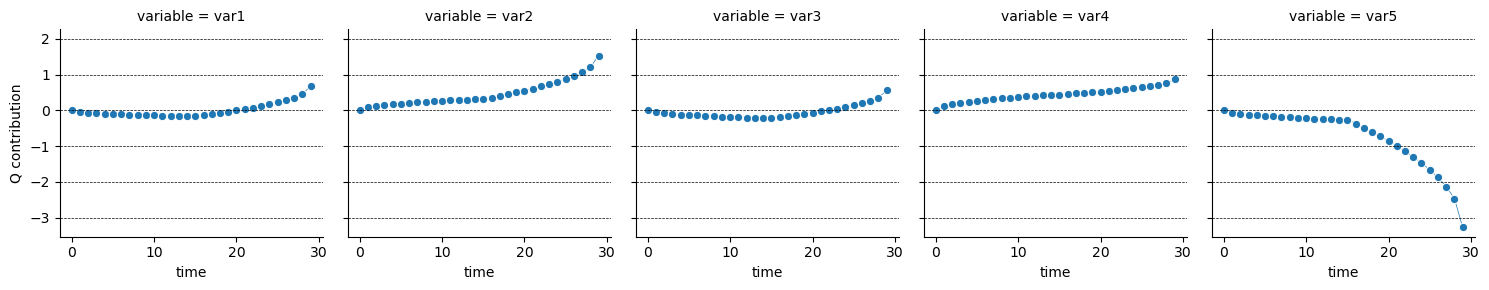

In [24]:
df = pd.DataFrame(contrib_Q, columns=variables).\
    reset_index().\
    melt(id_vars=["index"], value_vars=variables).\
    rename(columns={"index": "time"})
graph = sns.FacetGrid(df, col="variable")
graph.map_dataframe(sns.lineplot, x="time", y="value", lw=0.5, marker="o")
graph.set(ylabel="Q contribution")
x_axes = graph.axes.flatten()
for ax in x_axes:
  for i in range(-3,3):
    ax.axhline(i, ls="--", lw=0.5, c="black")

### T² contributions

In [25]:
pc_scaling = np.diag(np.power(pca_variances, -0.5))
pc_dist = test_scores @ pc_scaling
contrib_T2 = pc_dist @ np.transpose(pca_loadings)

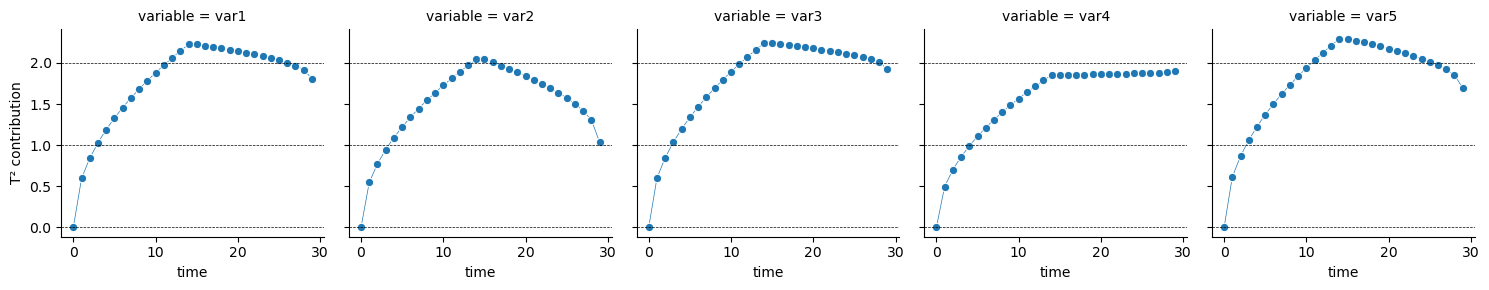

In [26]:
df = pd.DataFrame(contrib_T2, columns=variables).\
    reset_index().\
    melt(id_vars=["index"], value_vars=variables).\
    rename(columns={"index": "time"})
graph = sns.FacetGrid(df, col="variable")
graph.map_dataframe(sns.lineplot, x="time", y="value", lw=0.5, marker="o")
graph.set(ylabel="T² contribution")
x_axes = graph.axes.flatten()
for ax in x_axes:
  for i in range(0,3):
    ax.axhline(i, ls="--", lw=0.5, c="black")

(-1.0, 1.0)

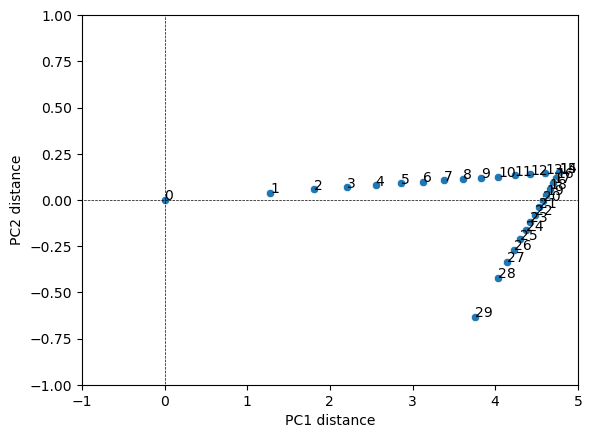

In [27]:
pc_dist_df = pd.DataFrame(pc_dist, columns=pc_names[:n_comp])
graph = sns.scatterplot(data=pc_dist_df, x="PC1", y="PC2")
graph.set(xlabel="PC1 distance", ylabel="PC2 distance")
graph.axhline(y=0,  xmin=-1, xmax=1, ls="--", lw=0.5, c="black")
graph.axvline(x=0,  ymin=-1, ymax=1, ls="--", lw=0.5, c="black")

for i in range(pc_dist.shape[0]):
    plt.annotate(i, (pc_dist[i,0], pc_dist[i,1]) )

graph.set_xlim(-1, 5)
graph.set_ylim(-1, 1)

Calculating T² without data denoising:

In [28]:
contrib_T2 = Z_test @ loadings @ np.diag(np.power(variances, -0.5)) @ np.transpose(loadings)


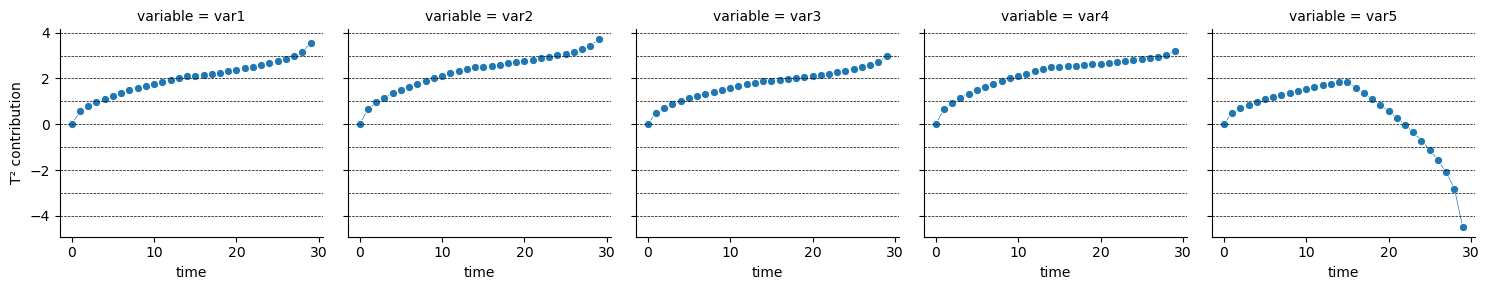

In [29]:
df = pd.DataFrame(contrib_T2, columns=variables).\
    reset_index().\
    melt(id_vars=["index"], value_vars=variables).\
    rename(columns={"index": "time"})
graph = sns.FacetGrid(df, col="variable")
graph.map_dataframe(sns.lineplot, x="time", y="value", lw=0.5, marker="o")
graph.set(ylabel="T² contribution")
x_axes = graph.axes.flatten()
for ax in x_axes:
  for i in range(-4,5):
    ax.axhline(i, ls="--", lw=0.5, c="black")